In [8]:
from pathlib import Path

import numpy as np
import pandas as pd

from numba import njit

from matplotlib import pyplot as plt

### Load data

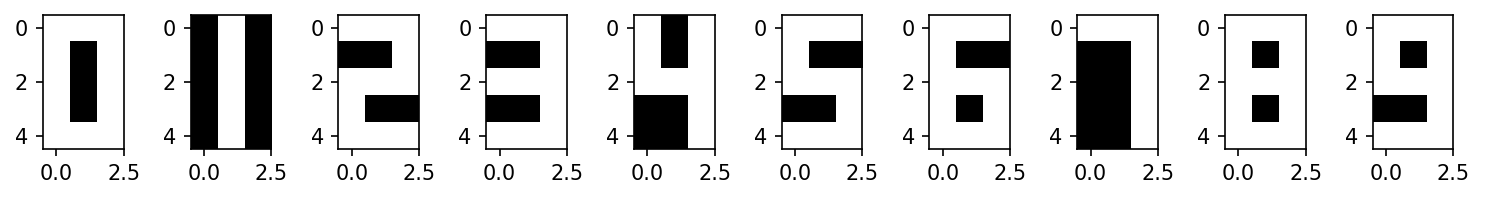

In [9]:
fig, axes = plt.subplots(nrows=1, ncols=10)

fig.set_dpi(150)
fig.set_figwidth(10)
fig.set_figheight(5)

nums_mtrx = np.loadtxt(Path('data', 'numbers_5x3.txt'))

img_shape = (5, 3)
img_size = 15

for n, ax in zip(nums_mtrx, axes.ravel()):
    ax.imshow(n.reshape(img_shape), cmap='binary_r')

plt.tight_layout()
plt.show()

### Generate dataset

In [10]:
cells_columns = [f'c{n}' for n in range(img_size)]
classes = ['zero', 'one', 'two', 'three', 'four', 'five', 'six', 'seven', 'eight', 'nine']

df = pd.DataFrame(columns=cells_columns + ['class'])

for i in range(10):
    new_row = dict(zip(cells_columns, nums_mtrx[i]))
    new_row['class'] = classes[i]

    df.loc[df.index.size] = new_row

    for j in range(9):
        noised_num = nums_mtrx[i] + np.random.uniform(0, 0.25, img_size)

        new_row = dict(zip(cells_columns, noised_num))
        new_row['class'] = classes[i]

        df.loc[df.index.size] = new_row

for name in df['class'].unique():
    df[f'{name}_label'] = df['class'].map(lambda x: 1 if x == name else 0)

### Split dataset to test and train

In [11]:
test_frac = 0.1

p = np.arange(10)

test_size = int(p.size * test_frac)
train_size = int(p.size * (1 - test_frac))

idx_test = np.ravel([(p[0:test_size] + i * 10) for i in range(10)])
idx_train = np.ravel([(p[test_size:p.size] + i * 10) for i in range(10)])

features_columns = cells_columns
label_columns = [f"{name}_label" for name in classes]

x_test = np.array(df.iloc[idx_test][features_columns])
y_test = np.array(df.iloc[idx_test][label_columns])

x_train = np.array(df.iloc[idx_train][features_columns])
y_train = np.array(df.iloc[idx_train][label_columns])

### Define activation functions

In [30]:
@njit(fastmath=True)
def relu(x: np.ndarray) -> np.ndarray:
    return np.maximum(np.zeros(x.shape), x)


@njit(fastmath=True)
def dRelu(x: np.ndarray) -> np.ndarray:
    return 1 * (x > 0)


@njit(fastmath=True)
def sigmoid(x: np.ndarray) -> np.ndarray:
    return 1 / (1 + np.exp(-x))


@njit(fastmath=True)
def dSigmoid(x: np.ndarray) -> np.ndarray:
    y = 1 / (1 + np.exp(-x))
    return y * (1 - y)


@njit(fastmath=True)
def softmax(x: np.ndarray) -> np.ndarray:
    y = np.exp(x)
    return y / np.sum(y)


@njit(fastmath=True)
def dist(a: np.ndarray, b: np.ndarray):
    return np.sum(np.square(a - b), axis=1)

### Define model

In [31]:
@njit(fastmath=True)
def grads(x_batch: np.ndarray, y_batch: np.ndarray, k: np.ndarray, c: np.ndarray, w:np.ndarray) -> tuple[np.ndarray]:
    dk = np.zeros(k.shape)
    dc = np.zeros(c.shape)
    dw = np.zeros(w.shape)
    
    for i in range(x_batch.shape[0]):
        d = dist(x_batch[i], c)
        h = np.exp(-k * d)
        y = softmax(w @ h)
        
        dk += -w.T @ (y - y_batch[i]) * d * h
        dc += np.atleast_2d(w.T @ (y - y_batch[i]) * h * 2 * k).T * (x_batch[i] - c)
        dw += np.outer((y - y_batch[i]), h)

    return (dk, dc, dw)


class Perceptron:
    def __init__(self, nIn: int, nRad: int, nOut: int) -> None:
        self.nIn = nIn
        self.nRad = nRad
        self.nOut = nOut
        
        self.k: np.ndarray = np.ones(nRad)
        self.c: np.ndarray = np.random.uniform(0, 1, (nRad, nIn))
        self.w: np.ndarray = np.random.uniform(-1, 1, (nOut, nRad))

    def predict(self, x: np.ndarray) -> np.ndarray:
        h = np.exp(-self.k * dist(self.c, x))
        return softmax(self.w @ h)

    def train(self, xTrain: np.ndarray, yTrain: np.ndarray, lr, batch_size, max_epoch) -> None:
        n = xTrain.shape[0]

        for epoch in range(max_epoch):
            idxs = np.random.permutation(n)

            for i in range(n//batch_size):
                ibegin = i * batch_size
                iend = min((i + 1) * batch_size, n - 1)
                batch_idxs = idxs[ibegin:iend]

                dk, dc, dw = grads(xTrain[batch_idxs], yTrain[batch_idxs], self.k, self.c, self.w)

                self.k -= lr * dk
                self.c -= lr * dc
                self.w -= lr * dw

    def loss(self, x: np.ndarray, y: np.ndarray) -> float:
        ypred = np.array([self.predict(xi) for xi in x])
        h = -np.mean(y * np.log(ypred), axis=1)
        return np.mean(h)

### Create and train model

In [37]:
nIn = 15
nRadial = 30
nOut = 10

learning_rate = 1e-1
batch_size = 8
max_epoch = 100

model = Perceptron(nIn, nRadial, nOut)

print('untrained loss: ', model.loss(x_test, y_test).round(4))

model.train(
    x_train,
    y_train,
    learning_rate,
    batch_size,
    max_epoch
)

print('trained loss: ', model.loss(x_test, y_test).round(4))

true_pos_count = 0
for x, y in zip(x_test, y_test):
    ypred = model.predict(x)
    true_pos_count += 1 if np.argmax(ypred) == np.argmax(y) else 0

accuracy = true_pos_count / x_test.shape[0]
print(f"test set accuracy: {round(accuracy * 100, 2)}%")

untrained loss:  0.2273
trained loss:  0.005
test set accuracy: 100.0%


### Test model on big number of noised samples

In [42]:
n_samples = 10000
noise_size = 0.25

true_pos_count = 0

for i in range(n_samples):
    j = i % 10
    x = nums_mtrx[j] + np.random.uniform(0, noise_size, img_size)
    ypred = model.predict(x)
    true_pos_count += 1 if j == np.argmax(ypred) else 0

accuracy = true_pos_count / n_samples

print(f"accuracy: {round(accuracy * 100, 2)}% ({true_pos_count} of {n_samples})")

accuracy: 100.0% (10000 of 10000)


### Visualize model predictions

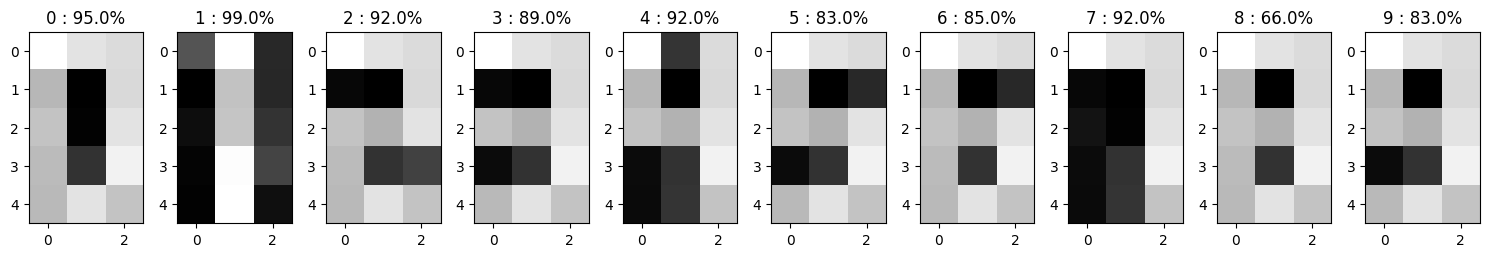

In [41]:
noise_size = 0.5
x_noised = nums_mtrx + np.random.uniform(0, noise_size, img_size)

ypred = list([model.predict(xi) for xi in x_noised])

fig, axes = plt.subplots(nrows=1, ncols=10)

fig.set_dpi(100)
fig.set_figwidth(img_size)
fig.set_figheight(5)

for i, ax in enumerate(axes.ravel()):
    ax.imshow(x_noised[i].reshape(img_shape),  cmap='binary_r')
    j = np.argmax(ypred[i])
    ax.set_title(f"{j} : {(ypred[i][j] * 100).round()}%")

plt.tight_layout()
plt.show()